In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# plotting 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


# Feature selection
from sklearn.feature_selection import mutual_info_classif
import scipy.stats as stats


# Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Models loading
import joblib

In [2]:
df = pd.read_excel("Dataset/student_helthcare_dataset_test.xlsx")

### Preprocessors and Models loading

In [3]:
scaler = joblib.load('scaler.pkl')
svm_model = joblib.load('svm_model.pkl')
DT_model = joblib.load('DT_model.pkl')
LR_model =  joblib.load('LR_model.pkl')
encoder = joblib.load('encoder.pkl')

### Functions

In [4]:
def ConvertAgerange(agesinyears):
    '''
    Converts ages in years to age ranges
    
    Args:
    - agesinyears (int): Age in years
    
    Returns:
    - str: Age range (child, adolescent, adult, elder)
    '''
    if agesinyears < 12:
        return 'Child'
    elif agesinyears < 20:  
        return 'Adolescent'
    elif agesinyears < 60: 
        return 'Adult'
    else:
        return 'Elder'

In [5]:
def categorize_billing_amount(amount):
    """
    Categorize billing amount into ranges (low, medium, high).

    Args:
        amount (float): Billing amount.

    Returns:
        str: Category (low, medium, high).
    """
    if amount < 5000:
        return 'Low'
    elif 5000 <= amount < 15000:
        return 'Medium'
    else:
        return 'High'


In [6]:
def handle_outlier(col, threshold=1.5):
    '''
    Function that gets maximum and minimum values for the provided column
    
    Args:
        col (pandas.Series): Column name
        threshold (float): Threshold value for defining outliers
    
    Returns:
        tuple: The lower and upper bounds for outliers
    '''
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = max(0, Q1 - (threshold * IQR))
    upper = Q3 + (threshold * IQR)
    return lower, upper

### Renaming and feature extraction

In [7]:
df.rename(columns={
    'Medical Condition': 'Medical_Condition',
    'Insurance Provider': 'Insurance_Provider',
    'Blood Type': 'Blood_Type',
    'Billing Amount': 'Billing_Amount',
    'Room Number': 'Room_Number',
    'Admission Type': 'Admission_Type',
    'Test Results': 'Test_Results'}, inplace=True)
df.rename(columns={'Date of Admission': 'Date_of_Admission', 'Discharge Date': 'Discharge_Date'}, inplace=True)

In [8]:
df.insert(2,"AgeRange",np.nan, True)
df.insert(11,"BillingRange",np.nan, True)

In [9]:
df['AgeRange'] = df['Age'].apply(ConvertAgerange)
df['BillingRange'] = df['Billing_Amount'].apply(categorize_billing_amount)

### Handling outliers nulls & duplicates

In [10]:
df['Billing_Amount'] = df['Billing_Amount'].round().astype(int)
# Modify the column in-place
df['Billing_Amount'] = df['Billing_Amount'].apply(lambda x: -x if x < 0 else x)
minimum, maximum = handle_outlier(df['Billing_Amount'])
# Replace values above the upper bound with the maximum value and values below the lower bound with the minimum value
df['Billing_Amount'] = np.where(df['Billing_Amount'] < minimum, minimum, df['Billing_Amount'])
df['Billing_Amount'] = np.where(df['Billing_Amount'] > maximum, maximum, df['Billing_Amount'])

In [11]:
df['Billing_Amount'] = np.where(df['Billing_Amount'] == 0 , df['Billing_Amount'].mean(), df['Billing_Amount'])

In [12]:
df['Room_Number'] = df['Room_Number'].apply(lambda x: -x if x < 0 else x)

In [13]:
# Fill null values with the most common medication for each medical condition
df['Medication'] = df['Medication'].fillna(df.groupby('Medical_Condition')['Medication'].transform(lambda x: x.mode().iloc[0]))

In [14]:
df.dropna(subset=['Medical_Condition'], inplace=True)

In [15]:
df.isnull().sum()

Name                  0
Age                   0
AgeRange              0
Gender                0
Blood_Type            0
Medical_Condition     0
Date_of_Admission     0
Doctor                0
Hospital              0
Insurance_Provider    0
Billing_Amount        0
BillingRange          0
Room_Number           0
Admission_Type        0
Discharge_Date        0
Medication            0
Test_Results          0
dtype: int64

In [16]:
df.duplicated().sum()

0

In [17]:
df['Date_of_Admission'] = pd.to_datetime(df.Date_of_Admission)
df['Discharge_Date'] = pd.to_datetime(df.Discharge_Date)

### Encoding data to use for model prediction

In [18]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = encoder.fit_transform(df[column])

### Data splitting

In [19]:
X = df[['Medical_Condition','Medication','Gender','Doctor','Billing_Amount','Admission_Type','AgeRange','Hospital']]
y = df['Test_Results']

In [20]:
X = scaler.fit_transform(X)

# Models

### SVC

In [21]:
SVM_Pred = svm_model.predict(X)

In [22]:
print(classification_report(y,SVM_Pred))

              precision    recall  f1-score   support

           0       0.54      0.49      0.51       351
           1       0.48      0.53      0.51       317

    accuracy                           0.51       668
   macro avg       0.51      0.51      0.51       668
weighted avg       0.51      0.51      0.51       668



In [23]:
SVC_accuracy = accuracy_score(y, SVM_Pred)
SVC_fscore = f1_score(y, SVM_Pred)

### Decision Tree

In [24]:
DT_Pred = DT_model.predict(X)

In [25]:
print(classification_report(y,DT_Pred))

              precision    recall  f1-score   support

           0       0.53      0.99      0.69       351
           1       0.67      0.02      0.04       317

    accuracy                           0.53       668
   macro avg       0.60      0.51      0.36       668
weighted avg       0.59      0.53      0.38       668



In [26]:
DT_accuracy = accuracy_score(y, DT_Pred)
DT_fscore = f1_score(y, DT_Pred)

### Logistic Regression

In [27]:
LR_ypred = LR_model.predict(X)

In [28]:
print(classification_report(y,LR_ypred))

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       351
           1       0.49      0.38      0.43       317

    accuracy                           0.51       668
   macro avg       0.51      0.51      0.50       668
weighted avg       0.51      0.51      0.51       668



In [29]:
LR_accuracy = accuracy_score(y, LR_ypred)
LR_fscore = f1_score(y, LR_ypred)

# Models Comparison

In [30]:
Models_Scores = pd.DataFrame({'Models':['SVC','Decision Tree','Logistic Regression'],
             'Accuracy':[SVC_accuracy,DT_accuracy,LR_accuracy],
             'Fscore': [SVC_fscore,DT_fscore,LR_fscore]})
Models_Scores.head()

,Models,Accuracy,Fscore
0,SVC,0.508982,0.506024
1,Decision Tree,0.529940,0.036810
2,Logistic Regression,0.514970,0.429577


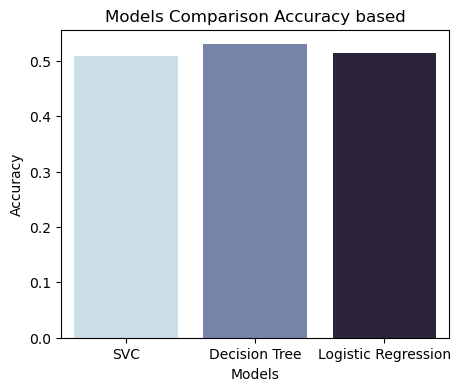

In [31]:
plt.figure(figsize=(5,4))
plt.title('Models Comparison Accuracy based')
figure = sns.barplot(x = Models_Scores['Models'],y = Models_Scores['Accuracy'],palette='ch:s=.25,rot=-.25', width=0.8)


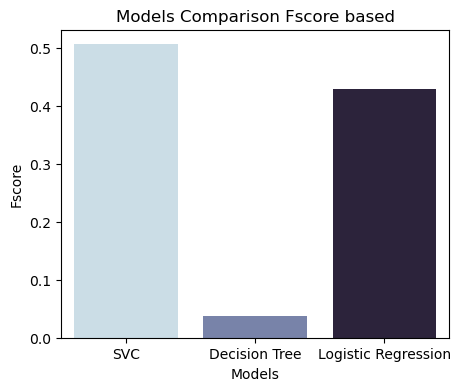

In [32]:
plt.figure(figsize=(5,4))
plt.title('Models Comparison Fscore based')
figure = sns.barplot(x = Models_Scores['Models'],y = Models_Scores['Fscore'],palette='ch:s=.25,rot=-.25', width=0.8)

**DT preformed slightly better that SVC in terms of accuracy on unseen data yet the SVC maintained it's top rank as the best in terms of fscore** 